# Example of usage Visual NLP for de-identify Dicom documents using ImageToTextV2 with Spark Structured Streaming

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-ac750be386cb)

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

In [ ]:
# NBVAL_SKIP
# install from PYPI using secret
%pip install --upgrade spark-nlp-jsl==4.4.0  --extra-index-url https://pypi.johnsnowlabs.com/$nlp_secret
%pip install spark-nlp==5.0.2
%pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
%pip install pydicom highdicom

## Initialization of spark session

In [2]:
from sparkocr import start
import os 

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal=f"{nlp_internal_version}")

spark

Spark version: 3.5.0
Spark NLP version: 5.2.2
Spark NLP for Healthcare version: 5.2.1
Spark OCR version: 5.2.0

:: loading settings :: url = jar:file:/opt/conda/envs/trocrMetrics/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-be10de1b-7ae2-40a7-868c-21d033409242;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.2.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.500 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in spark-list
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in spark-list
	found com.google.guava#guava;31.1-jre in spark-list
	found com.google

## Import Spark OCR transformers and Spark NLP annotators

In [3]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
from sparkocr.schemas import BinarySchema

from pyspark.ml import PipelineModel, Pipeline

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 5.2.2
Spark NLP internal version: 5.2.1
Spark OCR version: 5.2.0


## Define de-identification  NLP pipeline

In [4]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = DocumentNormalizer() \
      .setInputCols(prefix + "document_raw") \
      .setOutputCol(prefix + "document") \
      .setAction("clean") \
      .setPatterns(cleanUpPatterns) \
      .setReplacement(" ") \
      .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'ID',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            documentNormalizer,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [6]:
from pyspark.ml import PipelineModel, Pipeline

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("regions") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(1.0)

# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("regions") \
    .setOutputCol("dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    text_detector,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_generic_augmented"),
    position_finder
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


## Read dicom objects as binary file and display metadata

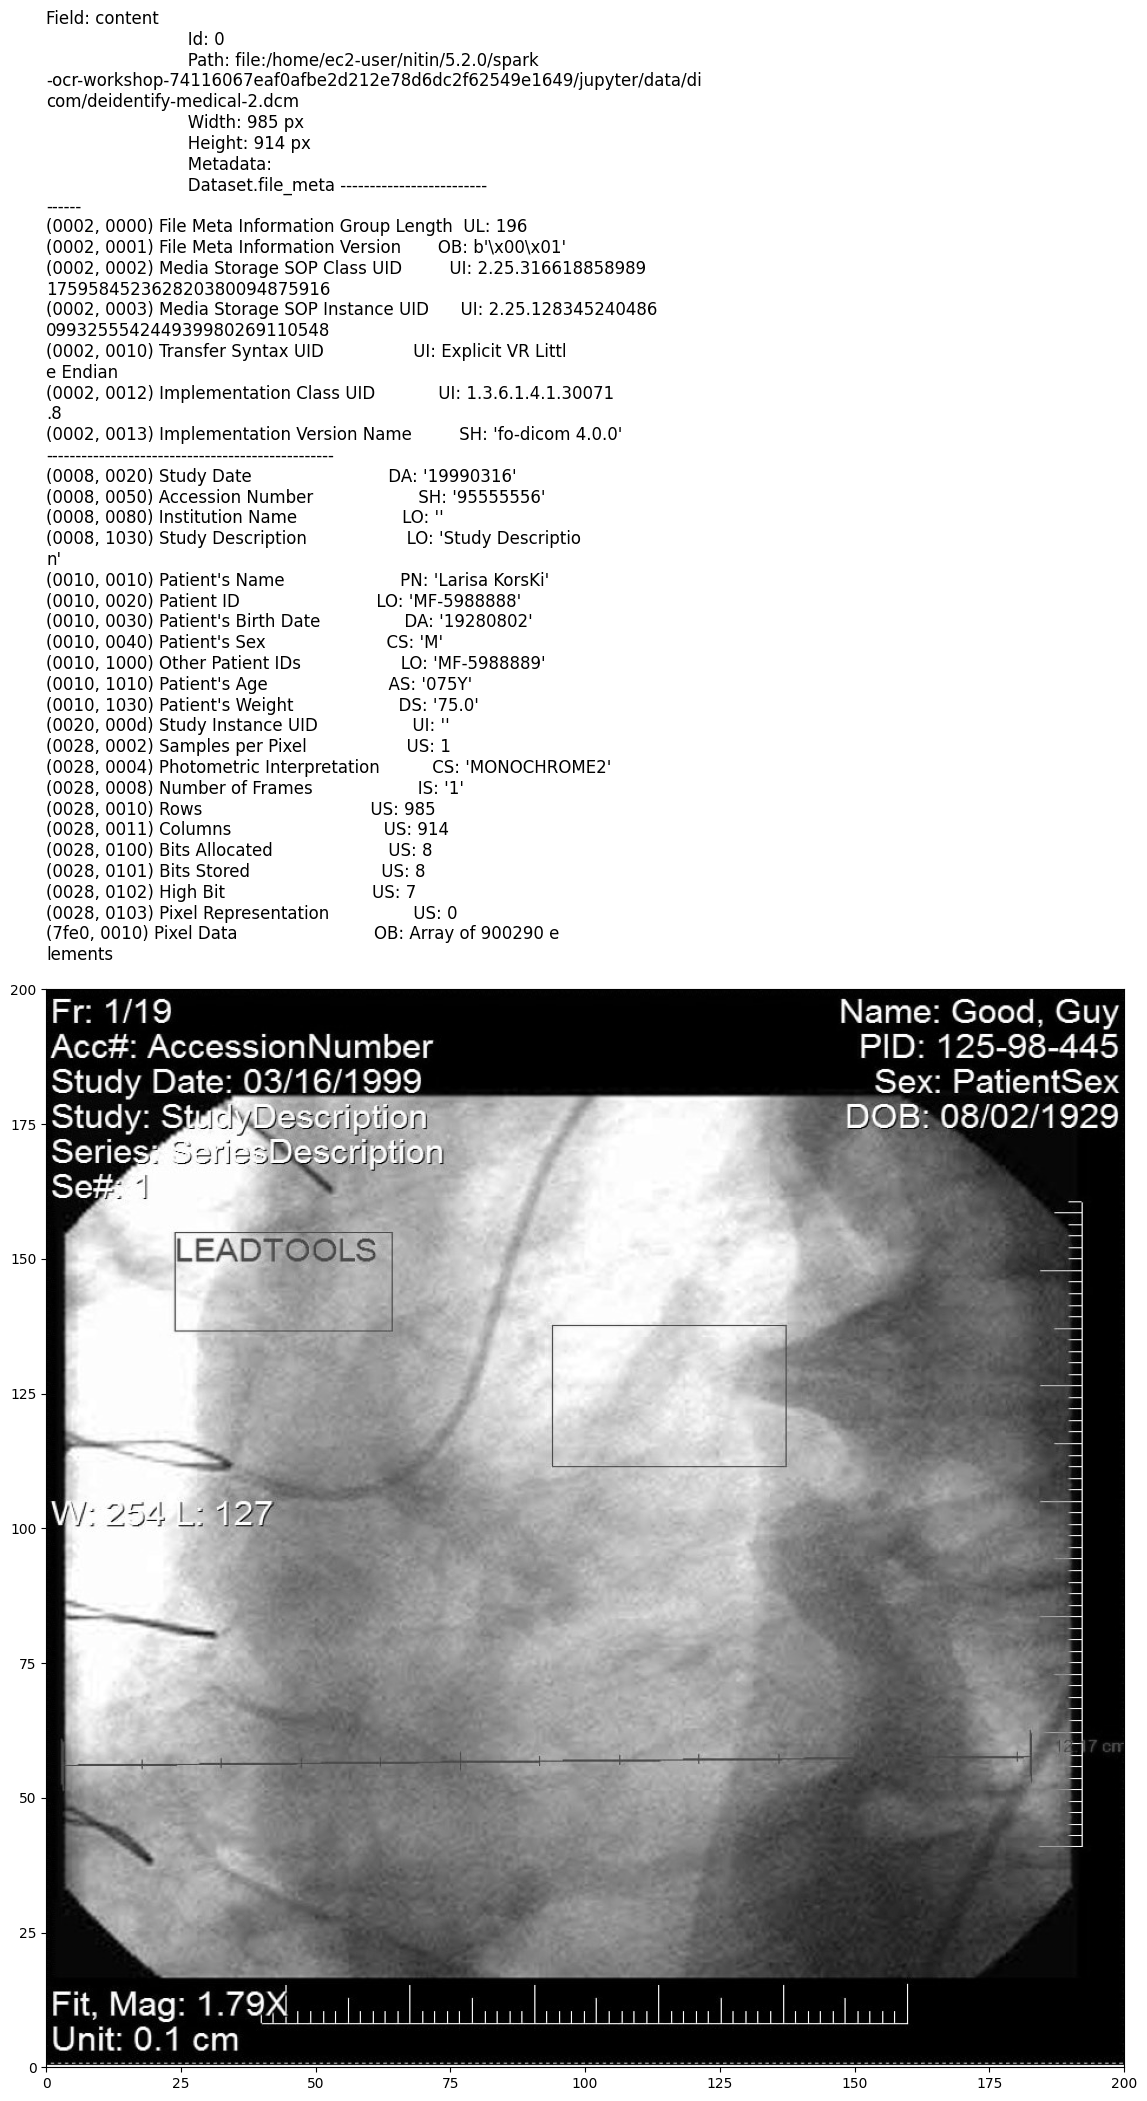

In [7]:
dicom_path = './../data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path).limit(1)

display_dicom(dicom_df)

## Define and start streaming query

In [8]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from urllib.parse import urlparse

# number of files in one microbatch
maxFilesPerTrigger = 1
outputPath = "./deidentified/"

# read files as stream
dicom_stream_df = spark.readStream \
    .format("binaryFile") \
    .schema(BinarySchema) \
    .option("maxFilesPerTrigger", maxFilesPerTrigger) \
    .load(dicom_path) \
    .withColumn("timestamp", current_timestamp()) \

# process files using OCR pipeline
result = pipeline.transform(dicom_stream_df).select("path", "regions", "exception")

def foreach_batch_function(df, epoch_id):

    def get_name(path, keep_subfolder_level=0):
        path = path.split("/")
        path[-1] = path[-1].split('.')[0]
        return "/".join(path[-keep_subfolder_level-1:])
    
    df1 = draw_regions.transform(df) \
      .withColumn("fileName", udf(get_name, StringType())(col("path"))) \
      .repartition(1)
    
    dicom_deidentifier.transform(df1).write \
      .format("binaryFormat") \
      .option("type", "dicom") \
      .option("field", "dicom_cleaned") \
      .option("nameField", "fileName") \
      .option("extension", "dcm") \
      .option("prefix", "de-id-") \
      .mode("append") \
      .save(outputPath)

query = result.writeStream.foreachBatch(foreach_batch_function) \
   .queryName('result') \
   .start()

01:39:16, INFO Callback Server Starting
01:39:16, INFO Socket listening on ('127.0.0.1', 39915)
24/02/27 01:39:16 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-ebf25c47-801c-4c8c-a508-8e340d077a22. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/02/27 01:39:16 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/02/27 01:39:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
01:39:17, INFO Python Server ready to receive messages
01:39:17, INFO Received command c on object id p0
01:39:24, INFO Run DicomToImageV3                                   (0 + 1) / 1]


## Check progress

Also please look Spark UI, Structured Streaming tab

In [11]:
query.lastProgress

{'id': 'c61b8b78-7e67-4251-8b67-910d9e061a90',
 'runId': '97b4993b-076f-4de7-a16b-1e24972e4d26',
 'name': 'result',
 'timestamp': '2024-02-27T01:43:05.204Z',
 'batchId': 3,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 1, 'triggerExecution': 2},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[file:/home/ec2-user/nitin/5.2.0/spark-ocr-workshop-74116067eaf0afbe2d212e78d6dc2f62549e1649/jupyter/data/dicom/*.dcm]',
   'startOffset': {'logOffset': 2},
   'endOffset': {'logOffset': 2},
   'latestOffset': None,
   'numInputRows': 0,
   'inputRowsPerSecond': 0.0,
   'processedRowsPerSecond': 0.0}],
 'sink': {'description': 'ForeachBatchSink', 'numOutputRows': -1}}

## Stop streaming query

In [12]:
query.stop()

## Check de-identified dicoms

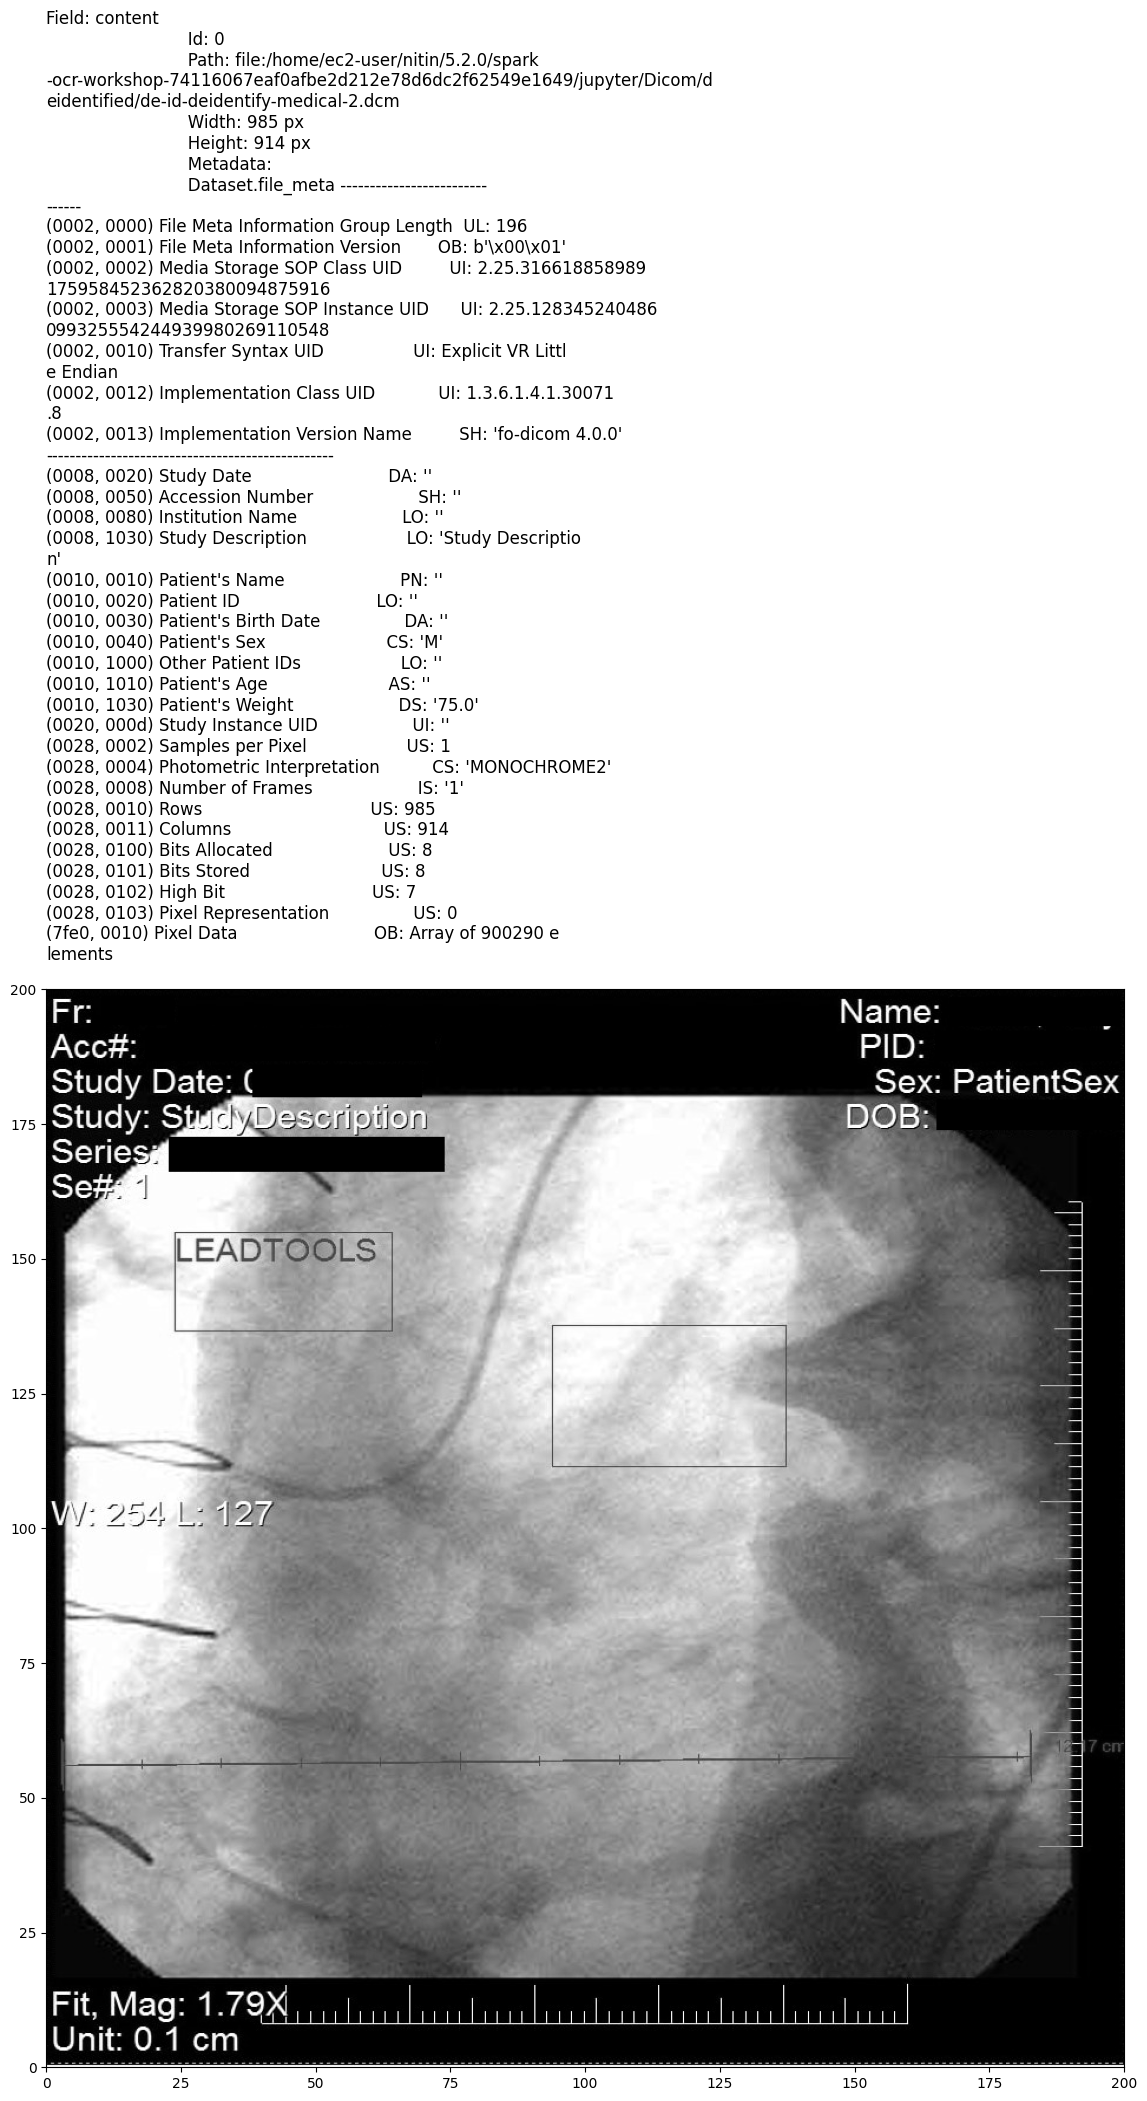

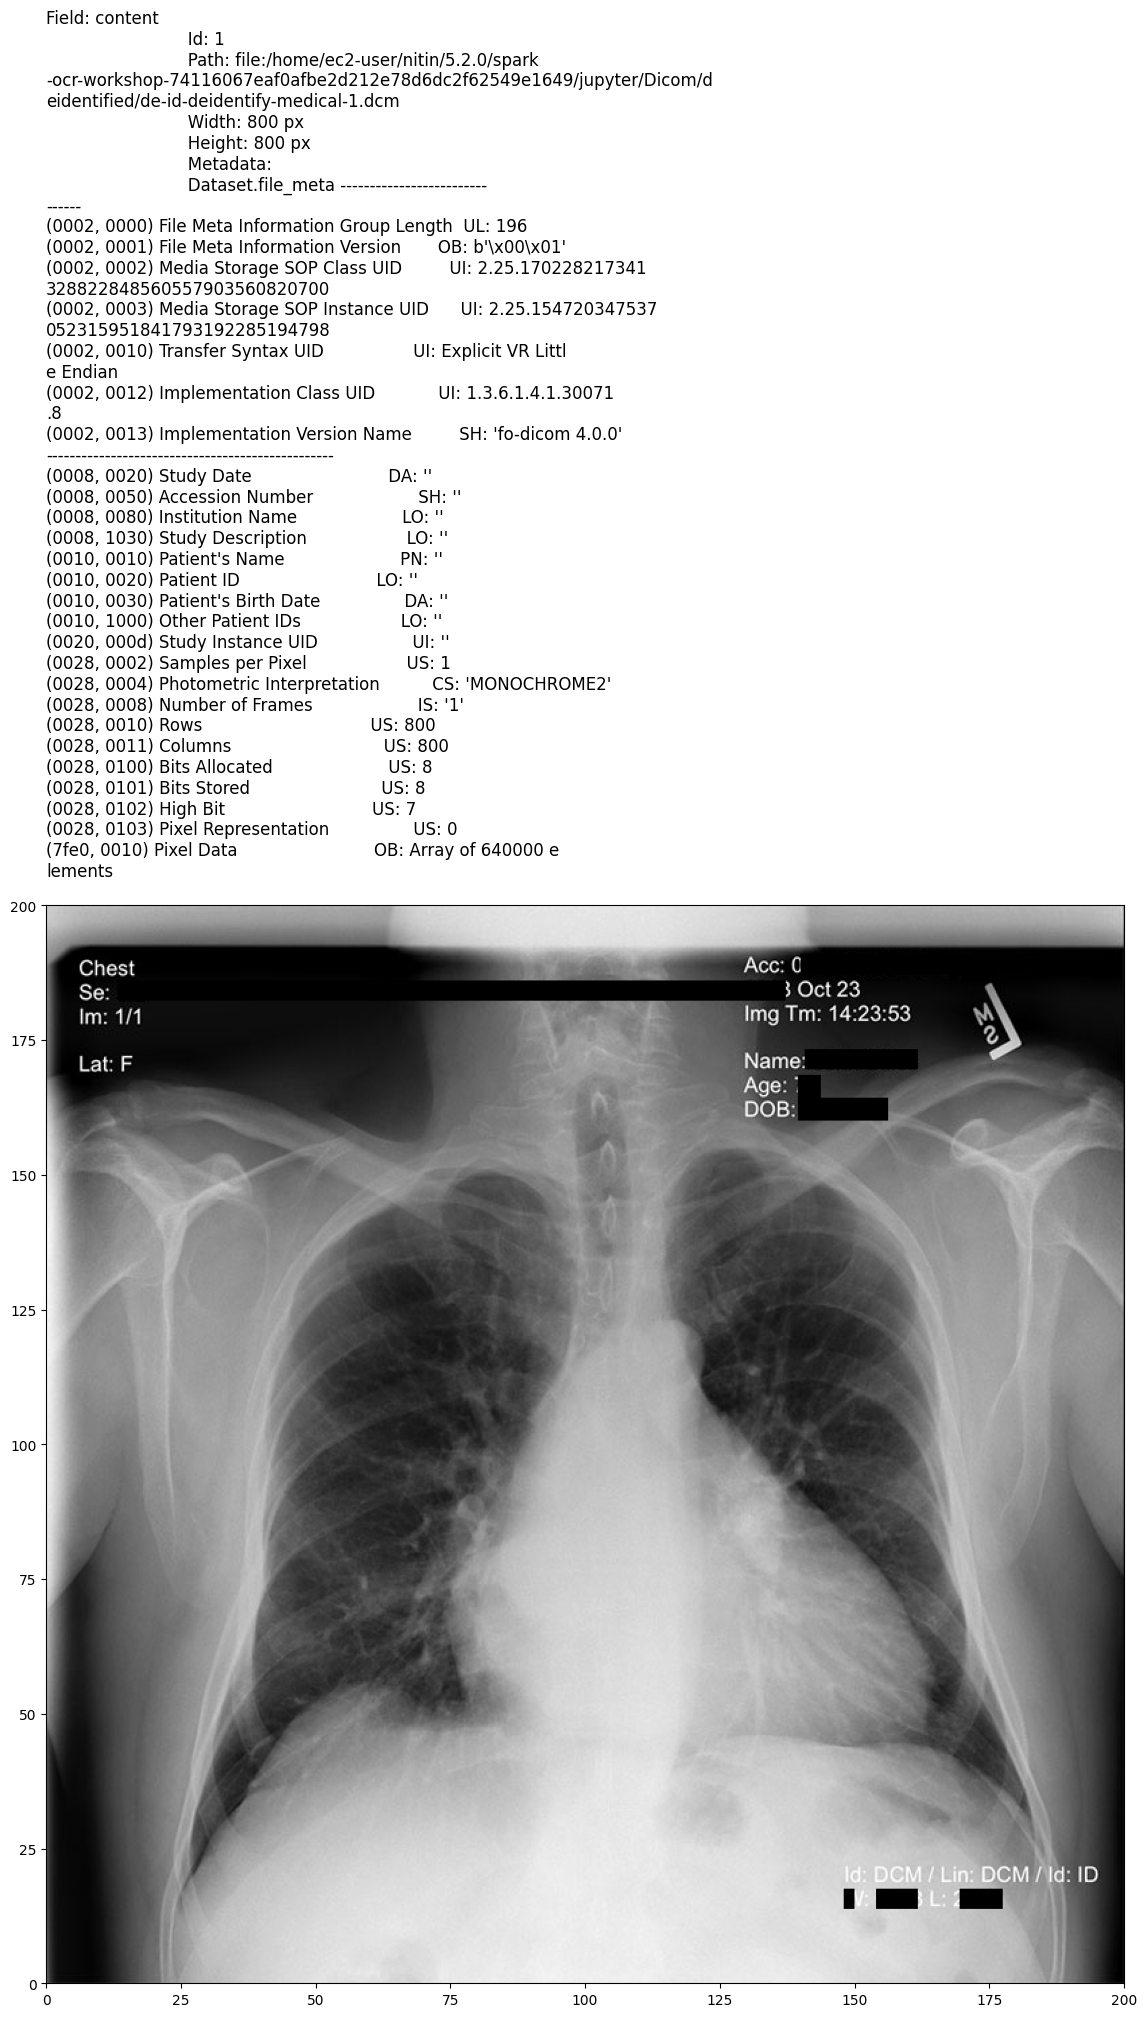

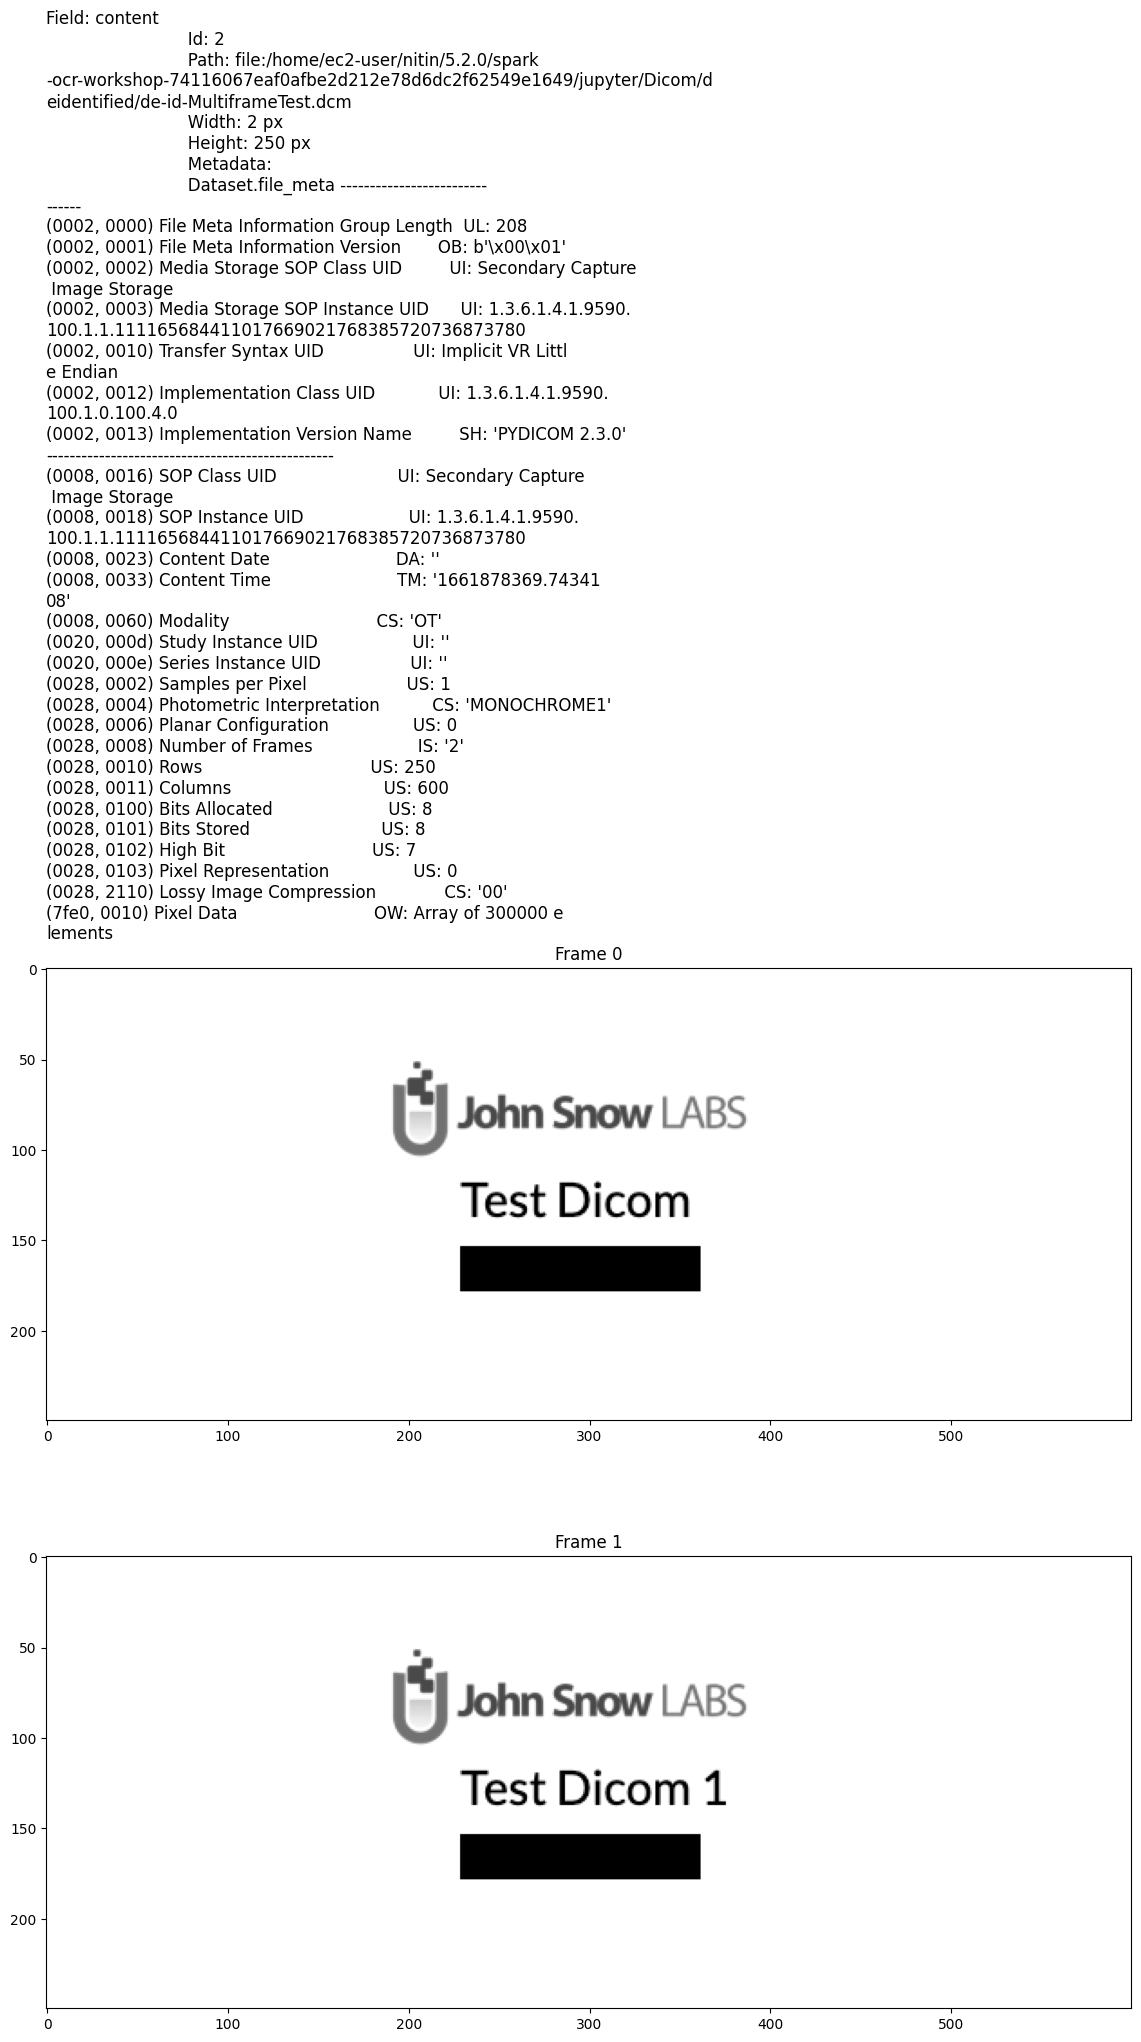

In [13]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load(outputPath + "*.dcm")

display_dicom(dicom_gen_df)